# Mushroom Prediction: A Preliminary Notebook

In [1]:
## This is a Juptyer notebook for the Kaggle Project: Mushroom Classification
# %pip install ydata-profiling
# %pip install numpy
# %pip install --upgrade pandas
# %pip install --upgrade matplotlib
# %pip install --upgrade seaborn
# %pip install --upgrade scikit-learn
# %pip install --upgrade scipy
# %pip install --upgrade catboost
# %pip install --upgrade xgboost
# %pip install --upgrade lightgbm
# %pip install ipywidgets


In [2]:
## Import libaries
import os

## Data analysis and wrangling
import numpy as np
import pandas as pd
import random as rnd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from ydata_profiling import ProfileReport
%matplotlib inline 
from scipy.stats import boxcox

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef


# Machine learning_ Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

# # Model selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


#Palette
palette = ['#328ca9', '#0e6ea9', '#2c4ea3', '#193882', '#102446']

# Set the style of the visualization
sns.set(style="whitegrid")

# Set the configuration of sklearn
SEED = 42 # for reproducibility

In [3]:
# Load the data and preprocessing
# Read the preprocessed data
dtype_spec = {
    'cap-diameter': 'float16',
    'stem-height': 'float16',
    'stem-width': 'float16',
    'does-bruise-or-bleed':'category',
    'has-ring':'category'
}


train_df = pd.read_csv(r'Output\\Cleaned_Data\\train_cleaned.csv',dtype=dtype_spec)
test_df = pd.read_csv(r'Output\\Cleaned_Data\\test_cleaned.csv',dtype=dtype_spec)
y = pd.read_csv(r'Output\\Cleaned_Data\\target.csv',dtype='category')

# Load the preprocessors
from joblib import load
preprocessor = load(r"Output/Models/preprocessor.pkl")
preprocessor_test = load(r"Output/Models/preprocessor_test.pkl")
le=load(r"Output/Models/label_encoder.pkl")

# Transform the data
X_prep = preprocessor.transform(train_df)
X_test_prep = preprocessor_test.transform(test_df)
y_prep=le.transform(y)

c:\Users\Kai Qi Yan\anaconda3\envs\MLEnv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## 6. 1st Level models

Then, we proceed to construct the 1st level models, which begins by defining the models (#6.1) and their parameters (#6.2). In this project, we will tune the hyperparameters by RandomizedSearchCV, and thus a parameter grid is defined in Section 6.2.

### 6.1. Model list

In [4]:
from utils import sort_dict

# Define a list of models for prediction
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=SEED),
    "Random Forest Classifier": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=SEED),
    "XGBClassifier": XGBClassifier(random_state=SEED),
    "MLP Classifier": MLPClassifier(random_state=SEED),
    "Extra Trees Classifier": ExtraTreesClassifier(random_state=SEED),
    "AdaBoost Classifier": AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1), algorithm='SAMME',random_state=SEED),
    "Dummy Classifier": DummyClassifier(strategy='prior',random_state=SEED)  # DummyClassifier for sanity check
}

# Sort the models
classifiers=sort_dict(classifiers)

### 6.2. Model parameters

In [5]:
# Define the parameters for the hyperparamter tuning of models by RandomizedSearchCV
import scipy.stats as stats

params_classifiers = {

    "Logistic Regression": {
        'solver': ['newton-cg', 'sag', 'lbfgs'],  
        'penalty': ['l2'],  
        'C': [0.1],
        'max_iter': [100, 200, 300]
    },

    "Random Forest Classifier": {
        'n_estimators': [64, 128, 256],
        'max_depth': [8, 16, 32, 64],
        'criterion': ['entropy'],
        'warm_start': [False]
    },

    "Gradient Boosting Classifier": {
        'learning_rate': stats.loguniform(1e-2, 1e-1),
        'n_estimators': [8, 16, 32, 64, 128, 256],
        'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
    },


    "XGBClassifier": {
            'objective':['binary:logistic'],
            'max_depth': [3, 5, 7, 9],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
            'n_estimators': [16, 32, 64, 128, 256]
        },


    "MLP Classifier": {
        'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': stats.loguniform(1e-5, 1e-2),
        'learning_rate': ['constant', 'adaptive']
    },
    
    "Extra Trees Classifier": {
        'n_estimators': [128, 256,524],
        'criterion': ['entropy'],
        'max_features': [10, 20, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'warm_start': [False]
    },

    "AdaBoost Classifier": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': stats.loguniform(1e-4, 1e-1),
    },

    "Dummy Classifier": {}
}

# Sort the parameters
params_classifiers = sort_dict(params_classifiers)

### 6.3. Model training and hyperparameters tuning

#### a. Setup scoring method for the model optimization

In [6]:
from sklearn.model_selection import StratifiedKFold

# Setup the KFold
NFOLDS = 3 # set folds for out-of-fold prediction
kf = StratifiedKFold(n_splits= NFOLDS,shuffle=True, random_state=SEED)

### 6.3.b. Hyperparameter tuning using a smaller set of data

<div style="border: 2px solid #999999; padding: 10px; border-radius: 5px; background-color: #282828; max-width: 97.5%; overflow-x: auto;">
<p>
<br>- Because we have a huge dataset, I decided to use a subset of which for tuning the hyperparameters and select models. The selected models will then be retrained in the whole dataset.
<br>- We made a subset of sample size= 100000, and
<br>- We selected models which show MCC score > 0.8 for further training.
</p>
</div>

In [7]:
from utils import model_evaluation

# Sampling data for hyperparameter tuning
sample_size = 100000  # sample size for tuning
X_sample, _, y_sample, _ = train_test_split(X_prep, y_prep, train_size=sample_size, shuffle=True, random_state=SEED, stratify=y)

# Split the data into training and validation sets
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_sample, y_sample, test_size=0.2, shuffle=True, random_state=SEED,stratify=y_sample)

# MCC Scores
model_list_tuning, MCC_train_list_tuning, MCC_val_list_tuning,y_train_pred_list_tuning, model_params_tuning = model_evaluation(classifiers, X_train_sample, y_train_sample, X_val_sample, y_val_sample, kf, params= params_classifiers, mode='tuning')

# Display the scores
pd.DataFrame(list(zip(model_list_tuning, MCC_train_list_tuning, MCC_val_list_tuning)), columns=['Model Name', 'MCC_Score_Train_sample', 'MCC_Score_val_sample']).sort_values(by=["MCC_Score_val_sample"],ascending=True)

Loading model: AdaBoost Classifier
Model-loading success: AdaBoost Classifier Best Parameters: {'algorithm': 'SAMME', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 1, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.006251373574521752, 'n_estimators': 200, 'random_state': 42}
Predicting
Model prediction success: AdaBoost Classifier MCC_train: 0.27887373091080625  , MCC_val: 0.26983651962177213


Loading model: Dummy Classifier
Model-loading success: Dummy Classifier Best Parameters: {'constant': None, 'random_state': 42, 'strategy': 'prior'}
Predicting
Model prediction success: Dum

,Model Name,MCC_Score_Train_sample,MCC_Score_val_sample
1,Dummy Classifier,0.000000,0.000000
0,AdaBoost Classifier,0.278874,0.269837
4,Logistic Regression,0.464186,0.457967
3,Gradient Boosting Classifier,0.841657,0.847661
5,MLP Classifier,0.979873,0.975384
2,Extra Trees Classifier,0.984945,0.976086
7,XGBClassifier,0.992864,0.978714
6,Random Forest Classifier,0.999950,0.980627


In [8]:
import copy
# Obtain a subset of models that has MCC_Score_val > 0.9
models_selected = []
parameters_selected =[]
for i in range(len(list(classifiers))):
    if MCC_val_list_tuning[i] > 0.9:
        print(list(classifiers.keys())[i])
        models_selected.append(list(classifiers.keys())[i])
        parameters_selected.append(model_params_tuning[i])

# Display the selected models
models_selected

# Select the models from the classifiers dictionary
classifiers_selected = {key: copy.deepcopy(classifiers[key]) for key in models_selected}

# add the parameters to the selected models
params_classifiers_selected = {key: parameters_selected[i] for i,key in enumerate(models_selected)}

Extra Trees Classifier
MLP Classifier
Random Forest Classifier
XGBClassifier


In [9]:
classifiers_selected 

{'Extra Trees Classifier': ExtraTreesClassifier(random_state=42),
 'MLP Classifier': MLPClassifier(random_state=42),
 'Random Forest Classifier': RandomForestClassifier(random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...)}

In [10]:
params_classifiers_selected

{'Extra Trees Classifier': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 10,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'monotonic_cst': None,
  'n_estimators': 256,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 'MLP Classifier': {'activation': 'tanh',
  'alpha': 0.0006173770394704573,
  'batch_size': 'auto',
  'beta_1': 0.9,
  'beta_2': 0.999,
  'early_stopping': False,
  'epsilon': 1e-08,
  'hidden_layer_sizes': (50, 100, 50),
  'learning_rate': 'constant',
  'learning_rate_init': 0.001,
  'max_fun': 15000,
  'max_iter': 200,
  'momentum': 0.9,
  'n_iter_no_change': 10,
  'nesterovs_momentum': True,
  'power_t': 0.5,
  'random_state': 42,
  'shuffle': True,
  'solver': 'sgd',
  'tol': 0.0001,
  'validation_fraction': 0.1,

In [11]:
# Split the entire data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_prep, y_prep, test_size=0.2, random_state=42, stratify=y)

# Train the selected models with the entire training data
model_list, MCC_train_list, MCC_val_list, y_train_pred_list, oof_predictions_df, val_predictions_df = model_evaluation(classifiers_selected , X_train, y_train, X_val, y_val, kf, params= params_classifiers_selected, mode='training')


Loading model: Extra Trees Classifier
Model-loading success: Extra Trees Classifier Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Predicting
Model prediction success: Extra Trees Classifier MCC_train: 0.9930108499161644  , MCC_val: 0.9790337592876035
Reading oof predictions and val predictions
Model: Extra Trees Classifier OOF predictions and val predictions read successfully


Loading model: MLP Classifier
Model-loading success: MLP Classifier Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_lay

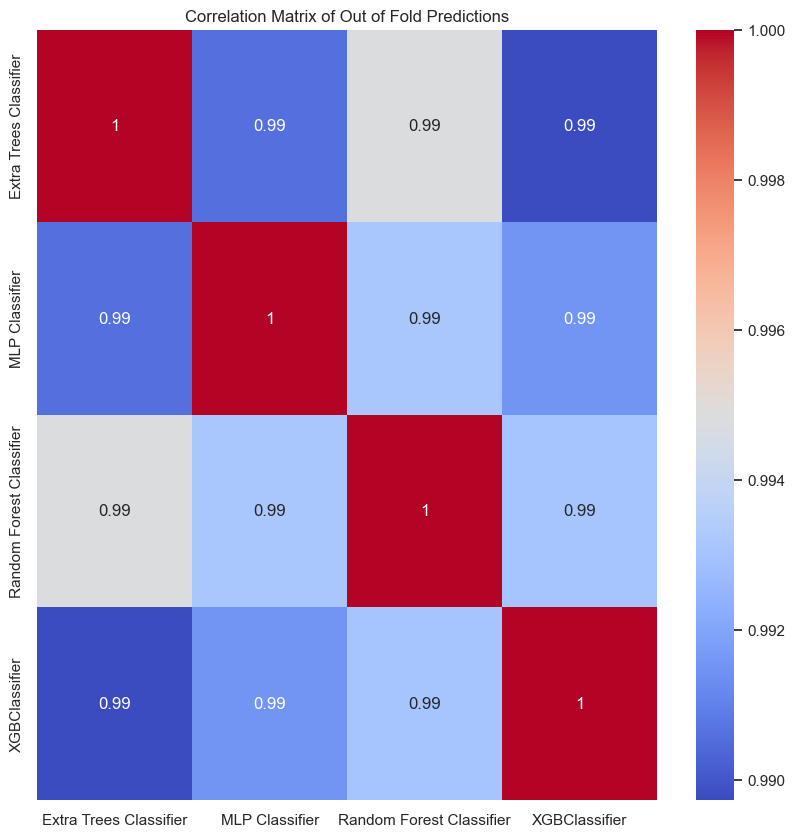

In [12]:
# plot a heatmap of the correlation matrix of the out of fold predictions
plt.figure(figsize=(10,10))
sns.heatmap(oof_predictions_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Out of Fold Predictions')
plt.show()

In [13]:
# Display the scores
pd.DataFrame(list(zip(model_list, MCC_train_list, MCC_val_list)), columns=['Model Name', 'MCC_Score_Train', 'MCC_Score_val']).sort_values(by=["MCC_Score_val"],ascending=True)

,Model Name,MCC_Score_Train,MCC_Score_val
0,Extra Trees Classifier,0.993011,0.979034
3,XGBClassifier,0.980365,0.979817
1,MLP Classifier,0.980514,0.979951
2,Random Forest Classifier,0.993848,0.981757


In [14]:
# Make predictions on the test dataset
test_predictions_df_selected = pd.DataFrame()
for i,key in enumerate (list(classifiers_selected.keys())):
    print ('=' * 100)
    print ('Loading model:', list(classifiers_selected)[i])
    with open((f"/kaggle/working/{list(classifiers_selected)[i]}"+"_training.pkl" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\Models\\{list(classifiers_selected)[i]}"+"_training.pkl"), 'rb') as file:
        model = load(file)
        print('Model-loading success:',classifiers_selected[key], 'Best Parameters:', model.get_params())
        test_predictions_df_selected[list(classifiers_selected.keys())[i]] = model.predict(X_test_prep)
        print('Predictions success:',list(classifiers_selected)[i])

Loading model: Extra Trees Classifier
Model-loading success: ExtraTreesClassifier(random_state=42) Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Predictions success: Extra Trees Classifier
Loading model: MLP Classifier
Model-loading success: MLPClassifier(random_state=42) Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': T

## 7. Meta-model via MLPClassifier

<div style="border: 2px solid #999999; padding: 10px; border-radius: 5px; background-color: #282828; max-width: 97.5%; overflow-x: auto;">
<p>
<br> - Next, we used the Out-of-fold predictions as inputs to train a, second-level, meta-model with MLPClassifier. 
<br> - the hyperparameters of the meta-model is also tuned by randomized search. 
</p>
</div>



In [15]:
from utils import MCC
## Train a meta model with the OOF predictions
# Define a MLP Classifier for the meta model
meta_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='tanh', solver='adam', alpha=0.0001, learning_rate='adaptive', random_state=SEED)

# Implement a randomized search for the meta-mode
params_meta = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': stats.loguniform(1e-5, 1e-2),
    'learning_rate': ['constant', 'adaptive']
}

# Setup the RandomizedSearchCV
RS_meta = RandomizedSearchCV(meta_model, params_meta, n_iter=10, cv=kf, scoring=make_scorer(MCC, greater_is_better=False),refit=True, n_jobs=-1, verbose=1)

# Fit the RandomizedSearchCV
RS_meta.fit(oof_predictions_df, y_train) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MLPClassifier(activation='tanh',
                                           hidden_layer_sizes=(50, 50, 50),
                                           learning_rate='adaptive',
                                           random_state=42),
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000173B3729310>,
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (50, 100, 50),
                                                               (100,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam']},
                   scoring=make_scorer(MCC, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [16]:
#  Produce the final predictions from the meta-model
y_val_meta = RS_meta.predict(val_predictions_df)
# Evaluate the meta-model
MCC_meta = MCC(y_val, y_val_meta)
print(f'The MCC score of the meta-model is: {MCC_meta}')

The MCC score of the meta-model is: 0.9820823339267337


In [17]:
from joblib import dump
# Obtain the best parameters of the meta-model
best_meta_model = RS_meta.best_estimator_
# Save the best meta-model

dump(best_meta_model, "/kaggle/working/meta_model.joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else "Output/meta_model.joblib", protocol=5)

# Make predictions on the test dataset
# load the meta model
meta_model = load("/kaggle/working/meta_model.joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else "Output/meta_model.joblib")
# Make predictions on the test dataset
test_predictions_meta = meta_model.predict(test_predictions_df_selected)

# Map predictions back to original labels
test_pred_class = le.inverse_transform(test_predictions_meta)

# Save the predictions in a csv file

submission_df = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv' if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else 'Input/sample_submission.csv')

submission_df['class'] = test_pred_class
submission_df.to_csv('/kaggle/working/submission.csv' if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else 'Output/submission.csv', index=False)


## 8. Conclusion

<div style="border: 2px solid #999999; padding: 10px; border-radius: 5px; background-color: #282828; max-width: 97.5%; overflow-x: auto;">
<p>
<br> In this project, we have successfully constructed a binary classifier for predicting whether a mushroom is edible or poisonous. 

<br> For Data-Cleaning: 
<br> - We cleaned the data by dropping features that has missing entries contributing more than 50% of their total count;
<br> - We grouped options with low frequencies into a new option " Other ";
<br> - We impute the mistyped entries and remaining missing entries with the most frequent option in the feature. 

<br> For Model construction:
<br> - We defined some typical classifier, tune their parameters and test their prediction performance over a subset of the training set; 
<br> - We selected models which gave MCC score > 0.8 to be further trained on the whole dataset and obtain Out-of-fold predictions. 
<br> - With the OOF predictions, we construct a meta-model with a MLPClassifier. 
<br> - the Constructed meta-model has a accuracy > 0.98. 

</p>
</div>


## 9. Future Improvements

1. Create additional features using AutoML
2. Conduct Exploratory Data analysis on the data
    -  Explore the possiblity to better imputing the missing values by correlating with other features.
3. Use lazypredict for selecting models
    https://github.com/shankarpandala/lazypredict 
4. Use Class for grouping functions.